# Example 1.0

We start with a simple example that uses scalar couplings as input for the BEM reweighting procedure. In this example, we consider a simulation of an RNA tetranucleotide for which NOE and 3J scalar couplings are available.

First, we import the module. It is possible to specify the location of the reweight.py script with sys.path.append.


In [1]:
# import the reweighting script
import os
import sys
cwd = os.getcwd()[:-8]
sys.path.append(cwd)
import reweight as rr

We now define the name of the files containing the experimental data...

In [2]:
# define name of experimental datafiles
exp_noe='../data/NOE_exp.dat'
exp_couplings = '../data/couplings_exp.dat'

... and of the corresponding quantities calculated from simulation


In [3]:
# define name of experimental quantities # calculated from the trajectory
calc_noe='../data/NOE_calc.dat'
calc_couplings = '../data/couplings_calc.dat'

We now intialize the reweight class by specifying the data we use as input, in this case J couplings. At initialization,  data are only parsed. It is EXTREMELY important that experimental and calculated data are ordered correctly, i.e. that column j+1 in the calculated datafile corresponds to the experimental quantity in row i+1 

In [4]:
# initialize reweighting class : use only couplings as input
rew = rr.Reweight([exp_couplings],[calc_couplings])


###### INITIALIZATION ########
# Read 26 JCOUPLINGS experimental datapoints
# Read 26 simulated datapoints from 20000 frames
# Warning: expt average 2-2H5P=0.5000     is smaller than minimum value in simulation 0.9920    
# Exp data shape  (26, 2)
# Simulation data shape  (20000, 26)
###### Initialization OK ########


a warning is issued whenever the experimental average is smaller (larger) than the minimum (maximum) value in simulation. This may or may not be an issue depending on the experimental uncertainty. 
The minimization of the cost function is performed by calling the function optimize:

In [5]:
# do optimization using theta=2
rew.optimize(theta=2.0, method="MAXENT")


Initial average chi squared     1.1525, srel     0.0000 
# Minimization successful
Final average chi squared       0.1785, srel     0.9829 


0

Here, we have set theta=2, but can be set to arbitrary values. By default, method="MAXENT" is used, meaning that the new weights are obtained by minimizing the maxent cost function (Eq. 6). It is also possible to use method="BER", so that Eq.7 is minimized instead. The results of the two minimization are identical (except for theta=0), but the BER is in general much slower, since the minimization is performed in n=20000 dimension. In the current implementation, the use of BER is in practice limited to ~1000 frames.

Now that the optimization is done, the new weights can be used to calculate any quantity of interest. First, we check that the agreement with the input data is improved, as expected. 


In [6]:
rew.weight_exp([exp_couplings],[calc_couplings] , 'example1.1')


# Read 26 JCOUPLINGS experimental datapoints
# Read 26 simulated datapoints from 20000 frames



The function weight_exp calculates the new weighted averages and outputs two files: example1.1.stats.dat and example1.1.weights.dat. Let's plot the first one 

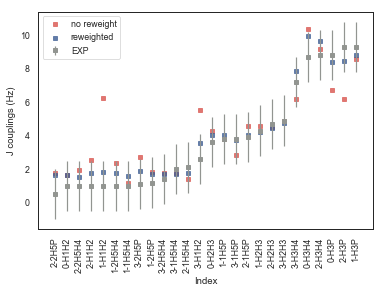

In [7]:
%matplotlib inline
# import numpy, matplotlib and seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# define some colors
sns.set_style("white")
sns.set_context("paper")
c1 = sns.xkcd_rgb["grey"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]
ff = "s"

# read data
data = []
labels = []
for line in open("example1.1.stats.dat"):
    if("#" in line): continue
    labels.append(line.split()[0])
    data.append([float(x) for x in line.split()[1:]])
data = np.array(data)


xx = np.arange(data.shape[0])
# sort to make it nicer
idxs = np.argsort(data[:,0])
new_labels = [labels[i] for i in idxs]

fig, ax1 = plt.subplots()
ax1.set_ylabel("J couplings (Hz)")
ax1.set_xlabel("Index")

ax1.errorbar(xx,data[idxs,0],yerr=data[idxs,1],c=c1,fmt=ff,markersize=4,label="EXP")
ax1.scatter(xx,data[idxs,2],marker=ff,c=c2,s=15,alpha=0.8,label="no reweight")
ax1.scatter(xx,data[idxs,3],marker=ff,c=c3,s=15,alpha=0.8,label="reweighted")

plt.xticks(xx,new_labels,rotation=90)

ax1.legend()

plt.show()

# plot lagrange multipliers
#lambdas = np.array([float(line.split()[1]) for line in open("lambda.dat") if "#" not in line])
#ax2 = ax1.twinx()
#ax2.scatter(xx,lambdas[idxs]/data[idxs,0],c='g')
#ax2.set_ylim(-0.3,0.3)


Since we also have NOE data, we can check whether the new weights, obtained by matching scalar couplings, improve the agreement with NOEs as well. Again, we call the function  reweight_exp

# Read 27 NOE experimental datapoints
# Read 27 simulated datapoints from 20000 frames


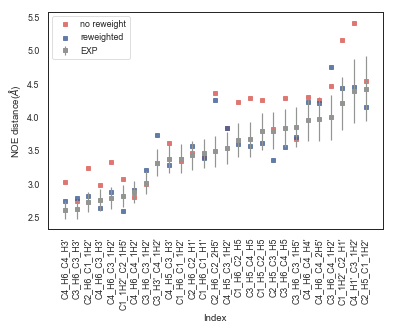

In [8]:
rew.weight_exp([exp_noe],[calc_noe] , 'example1.2')
# read data
data = []
labels = []
for line in open("example1.2.stats.dat"):
    if("#" in line): continue
    labels.append(line.split()[0])
    data.append([float(x) for x in line.split()[1:]])
data = np.array(data)


xx = np.arange(data.shape[0])
# sort to make it nicer
idxs = np.argsort(data[:,0])
new_labels = [labels[i] for i in idxs]

fig, ax1 = plt.subplots()
ax1.set_ylabel("NOE distance($\AA$)")
ax1.set_xlabel("Index")

ax1.errorbar(xx,data[idxs,0],yerr=data[idxs,1],c=c1,fmt=ff,markersize=4,label="EXP")
ax1.scatter(xx,data[idxs,2],marker=ff,c=c2,s=15,alpha=0.8,label="no reweight")
ax1.scatter(xx,data[idxs,3],marker=ff,c=c3,s=15,alpha=0.8,label="reweighted")

plt.xticks(xx,new_labels,rotation=90)

ax1.legend()

plt.show()


It is also possible to use the weights before and after optimization, to understand what is the effect of reweighting.  We first plot the weight themselves. If many weights are zero, and only a few are non-zero, it might be a sign of incomplete sampling, or inaccurate force-field. 


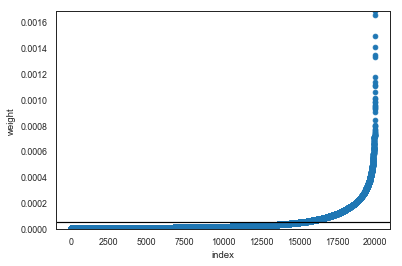

In [9]:
weights = np.array([[float(x) for x in line.split()] for line in open("example1.1.weights.dat") if "#" not in line])
xx1 = np.arange(weights.shape[0])
ss = np.argsort(weights[:,1])
plt.scatter(xx1,weights[ss,1])
# draw horizontal line showing value of the initial weights (all identical in this case)
plt.axhline(weights[0,0],c='k')
plt.ylabel("weight")
plt.xlabel("index")
plt.ylim(0,np.max(weights))
plt.show()

The weights can be used to calculate distributions of any quantity. As an example, we read from a file the distance from a reference structure (A-form)


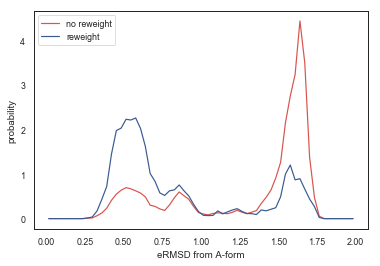

In [10]:
data = np.array([float(line.split()[1]) for line in open("../data/ermsd.opc.dat") if "#" not in line])
plt.ylabel("probability")
plt.xlabel("eRMSD from A-form")
bins = np.linspace(0,2,65)

###########
hh_0, ee_0 = np.histogram(data,normed=True,bins=bins)
hh_star, ee_1 = np.histogram(data,normed=True,bins=bins,weights=weights[:,1]) 
###########
xx = 0.5*(ee_0[1:]+ee_0[:-1])
plt.plot(xx,hh_0,color=c2,label="no reweight")
plt.plot(xx,hh_star,color=c3,label="reweight")
plt.legend()
plt.show()